In [3]:
import json
import pandas as pd
import numpy as np
from scipy import interpolate, stats
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from datetime import datetime
import websocket
import pytz
from scipy.optimize import fsolve
from time import sleep

from option_dataset import *

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size'] = '16'


In [4]:
save_plot = True

# Simple download function
It works. But, it is not meant to be a good example. 

In [5]:
ws_live = 'wss://www.deribit.com/ws/api/v2'
def get_tickers(currency, kind, sleep_in_sec = 0.05):

    msg_instruments = {
        "jsonrpc": "2.0",
        "id": 12345, 
        "method": "public/get_instruments",
        "params":{
            "currency": currency, 
            "kind": kind, 
            "expired": False
        }
    }

    ws = websocket.WebSocket()
    ws.connect(ws_live)
    ws.send(json.dumps(msg_instruments))
    insts_out = json.loads(ws.recv())
    ticks = []
    for inst in insts_out['result']:
        name = inst['instrument_name']
        msg_tick = {
            "jsonrpc": "2.0", 
            "id": 1234, 
            "method": "public/ticker", 
            "params":{
                "instrument_name": name
            }
        }
        ws.send(json.dumps(msg_tick))
        tick_out = json.loads(ws.recv())
        ticks.append(tick_out)
        sleep(sleep_in_sec)
    ws.close()
    return insts_out, ticks


# Data download and preparation

In [6]:
dt_now = datetime.now()
now_str = dt_now.strftime('%Y%m%d%H%M%S')

In [7]:
b_download = False
date_str = '20220817220159'
fn_insts, fn_ticks = [h + '_' + date_str + '.pkl' for h in ['insts', 'ticks']]
if b_download:
    # this takes time (e.g. 1 mins). so, do not call unless it is required
    opts_insts, opts_ticks = get_tickers('ETH', 'option')
    # creating the data set
    df_opts_insts = pd.DataFrame([i for i in opts_insts['result']])
    df_opts_ticks = pd.DataFrame([ot['result'] for ot in opts_ticks])
    df_opts_insts.to_pickle(fn_insts)
    df_opts_ticks.to_pickle(fn_ticks)
else:
    df_opts_insts = pd.read_pickle(fn_insts)
    df_opts_ticks = pd.read_pickle(fn_ticks)

# merge data
df_opts_md = pd.merge(df_opts_ticks, df_opts_insts, how='left', on='instrument_name')[['option_type', 'instrument_name', 'expiration_timestamp', 'strike', 'underlying_price', 'timestamp', 'mark_price', 'mark_iv', 'bid_iv', 'ask_iv', 'greeks']]
df_opts_md = pd.concat([df_opts_md, pd.DataFrame({i:r['greeks'] for i, r in df_opts_md.iterrows()}).T], axis=1)

df_opts_md.columns

Index(['option_type', 'instrument_name', 'expiration_timestamp', 'strike',
       'underlying_price', 'timestamp', 'mark_price', 'mark_iv', 'bid_iv',
       'ask_iv', 'greeks', 'vega', 'theta', 'rho', 'gamma', 'delta'],
      dtype='object')

In [8]:
ods = OptionDataset(df_opts_md)

## Forwards
They keep the underlying price - which is where call & put prices are the same. 
In other words, Forward Price. 

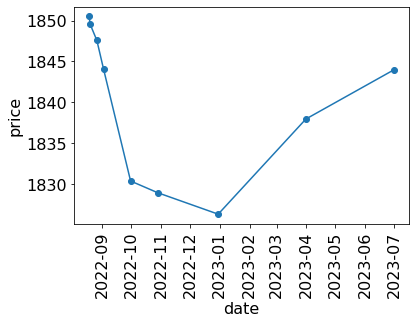

In [9]:
ds = ods.ds_fwd
x, y = [timestamp2datetime(ts) for ts in ds.index], ds.to_numpy()
fig = plt.figure()
plt.plot(x, y, 'o-')
plt.xticks(rotation = 90)
plt.xlabel('date'), plt.ylabel('price')
plt.show()

## Implied Volatilities

In [10]:
df_delta_id = get_delta_id_df()

In [11]:
expiration_idx = 2
expiration_timestamp = ods.expiration_timestamps[expiration_idx]
expiration_datetime = timestamp2datetime(expiration_timestamp)
df_p = ods[expiration_idx]
df_pc, df_pp = df_p['call'], df_p['put']

KeyError: 'call'

In [84]:
infer_iv_at_deltas(df_pc, df_delta_id['call'].to_numpy())

(array([1535.375166  , 1695.79144658, 1864.31352845, 2039.92183602,
        2230.45757865]),
 array([100.46729084,  92.98002556,  88.5209446 ,  87.60557791,
         90.82520496]),
 array([ True,  True,  True,  True,  True]))

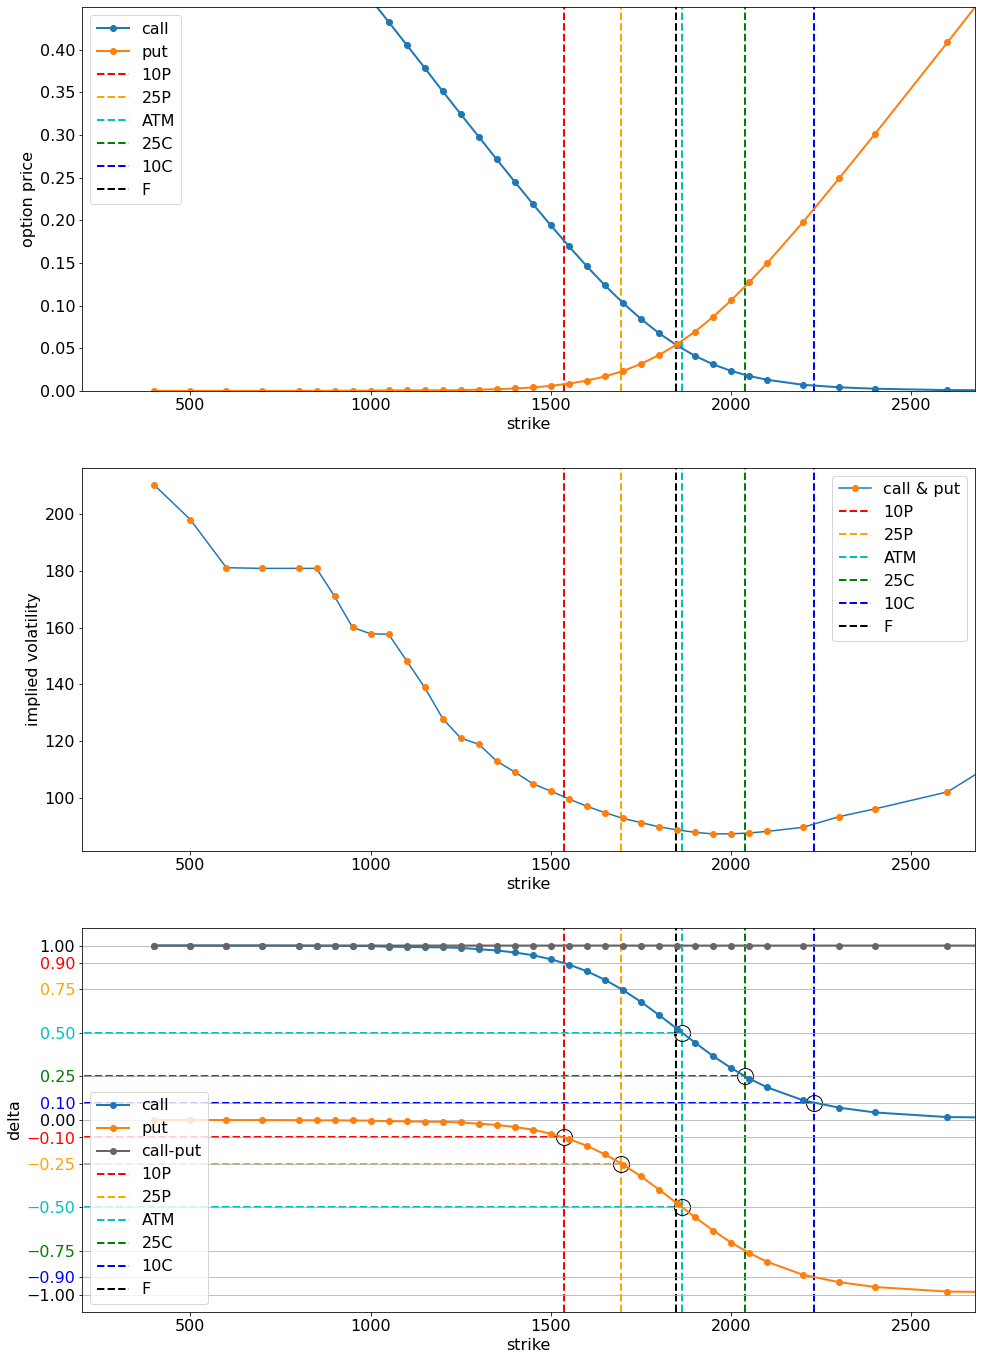

In [63]:
# plotting - what a big cell (programming like no future)



fwd = np.mean(df_pc['underlying_price'])
col_mk = np.ones(3) * 0.4
fwk_mk = 's'
m_mk = 'o'

df_delta_tag = pd.DataFrame(data=[['10P',.90], ['25P',.75], ['ATM',.5], ['25C', .25], ['10C', .10]], columns=['tag','delta'])
#df_delta_tag = pd.DataFrame(data=[['10P',.90], ['25P',.75], ['ATM',.5], ['25C', .25]], columns=['tag','delta'])

delta_m = df_delta_tag['delta'].to_numpy()
strike_m = my_interp1d(df_pc['delta'], df_pc['strike'])(delta_m)
iv_m = my_interp1d(df_pc['strike'], df_pc['mark_iv'])(strike_m)
fnPk = lambda k: my_interp1d(df_pp['strike'], df_pp['mark_price'])(k)

df_iv_m = pd.DataFrame({'tag':df_delta_tag['tag'], 'iv':iv_m})

xlim = [0.5*df_pc['strike'].min(), strike_m.max()*1.2]

vlines = np.hstack([strike_m, fwd])
vline_tags = np.hstack([df_delta_tag['tag'].to_numpy(), 'F'])

m_colors = ['red','orange','c','green','blue','k']

def plot_v(ax, horz=None):
    av, tag = vlines, vline_tags
    tform = blended_transform_factory(ax.transData, ax.transAxes)

    if horz is None:
        for i, (v,t) in enumerate(zip(av,tag)):
            plt.axvline(v, color=m_colors[i], 
                    ls='--', zorder = -100, lw=2, label=t)

            # ax.annotate(t, xy=(v, 0), xycoords=tform, 
            # xytext=(v, 0.75 if t=='F' else 0.9), textcoords=tform,
            # ha='left', va='center', color=m_colors[i])

    if horz is not None:
        for i, h in enumerate(horz):
            if h is not None:
                plt.hlines(h, xmin=0, xmax=av[i], color=m_colors[i], ls='--', zorder=-100, lw=2)

plt.figure(figsize=(16,24))
ax1 = plt.subplot(3,1,1)


line_c,=plt.plot(df_pc['strike'], df_pc['mark_price'], '.-', lw=2, ms=12, label='call')
line_p,=plt.plot(df_pp['strike'], df_pp['mark_price'], '.-', lw=2, ms=12, label='put')
plt.xlim(xlim)
plot_v(ax1)
#plt.xscale('log')
plt.ylim([0, fnPk(xlim[1])])
plt.ylabel('option price'), plt.xlabel('strike')
plt.legend()

ax2=plt.subplot(3,1,2, sharex=ax1)
plt.plot(df_pc['strike'], df_pc['mark_iv'], '.-', ms=12, c=line_c.get_color(), markerfacecolor=line_p.get_color(), markeredgecolor=line_p.get_color(), label='call & put')
#plt.plot(df_pc['strike'], df_pc['mark_iv'], '-', lw=2, label='call & put')
#plt.plot(strike_m, iv_m, m_mk, color=col_mk, ms=8, zorder = -10)
plot_v(ax2)
plt.legend()
plt.ylabel('implied volatility'), plt.xlabel('strike')

ax3=plt.subplot(3,1,3, sharex=ax1)
line, = plt.plot(df_pc['strike'], df_pc['delta'], '.-', lw=2, ms=12, label='call')
idx_c = delta_m < 0.6
plt.plot(strike_m[idx_c], delta_m[idx_c], 'o', color='k', markerfacecolor='none', lw=2, ms=16, zorder=-5)
#plt.plot(np.log(df_pc['strike']), ss.norm.ppf(df_pc['delta']), '.')
line, = plt.plot(df_pc['strike'], df_pp['delta'], '.-', lw=2, ms=12, label='put')
idx_p = delta_m > 0.4
plt.plot(strike_m[idx_p], delta_m[idx_p] - 1, 'o', color='k', markerfacecolor='none', lw=2, ms=16, zorder=-5)

line, = plt.plot(df_pc['strike'], df_pc['delta'].to_numpy()-df_pp['delta'].to_numpy(), '.-', c = col_mk, lw=2, ms=12, label='call-put')

plot_v(ax3)
plot_v(ax3, [-0.1,-0.25, -0.5, None, None])
plot_v(ax3, [None, None, 0.5, 0.25, 0.1])

plt.grid(axis='y', zorder=-20)
plt.yticks(np.hstack([1., delta_m, 0, -np.flip(delta_m), -1]))

ax3.get_yticklabels()[7].set_color(m_colors[0])
ax3.get_yticklabels()[8].set_color(m_colors[1])
ax3.get_yticklabels()[9].set_color(m_colors[2])
ax3.get_yticklabels()[10].set_color(m_colors[3])
ax3.get_yticklabels()[11].set_color(m_colors[4])

ax3.get_yticklabels()[1].set_color(m_colors[0])
ax3.get_yticklabels()[2].set_color(m_colors[1])
ax3.get_yticklabels()[3].set_color(m_colors[2])
ax3.get_yticklabels()[4].set_color(m_colors[3])
ax3.get_yticklabels()[5].set_color(m_colors[4])


plt.ylabel('delta'), plt.xlabel('strike')
plt.legend()
if save_plot:
    plt.sca(ax1)
    plt.savefig('rr-st.png', bbox_inches='tight')
plt.show()



In [64]:
timestamp2datetime(df_pc['timestamp'].iloc[-1])

datetime.datetime(2022, 8, 17, 22, 0, 36, 412000)

In [65]:
# summary
print('expiry', expiration_datetime)
display(df_iv_m)
print('forward', fwd)

expiry 2022-08-26 09:00:00


,tag,iv
0,10P,100.467291
1,25P,92.980026
2,ATM,88.520945
3,25C,87.605578
4,10C,90.825205


forward 1847.5768292682926
